In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv("obesity_prediction.csv")

In [3]:
df

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [4]:
df.isnull().sum()

Gender            0
Age               0
Height            0
Weight            0
family_history    0
FAVC              0
FCVC              0
NCP               0
CAEC              0
SMOKE             0
CH2O              0
SCC               0
FAF               0
TUE               0
CALC              0
MTRANS            0
Obesity           0
dtype: int64

In [5]:
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    print(f"{column} unique values: {df[column].unique()}")

Gender unique values: ['Female' 'Male']
family_history unique values: ['yes' 'no']
FAVC unique values: ['no' 'yes']
CAEC unique values: ['Sometimes' 'Frequently' 'Always' 'no']
SMOKE unique values: ['no' 'yes']
SCC unique values: ['no' 'yes']
CALC unique values: ['no' 'Sometimes' 'Frequently' 'Always']
MTRANS unique values: ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
Obesity unique values: ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


In [6]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [7]:
insufficient_weight_obesity = df[df['Obesity'] == 'Insufficient_Weight']

print(insufficient_weight_obesity)


     Gender        Age    Height     Weight family_history FAVC      FCVC  \
59     Male  20.000000  1.760000  55.000000            yes  yes  2.000000   
71   Female  22.000000  1.670000  50.000000            yes   no  3.000000   
75   Female  23.000000  1.630000  45.000000            yes   no  3.000000   
76   Female  24.000000  1.600000  45.000000            yes   no  2.000000   
83   Female  19.000000  1.600000  45.000000             no   no  3.000000   
..      ...        ...       ...        ...            ...  ...       ...   
740  Female  19.000000  1.531610  42.000000             no  yes  2.749268   
741  Female  19.434709  1.525691  42.000000             no  yes  3.000000   
742    Male  18.000000  1.719827  52.289828            yes  yes  1.202075   
743    Male  18.381382  1.722547  53.783977            yes  yes  2.000000   
744    Male  18.000000  1.738702  50.248677            yes  yes  1.871213   

          NCP        CAEC SMOKE      CH2O  SCC       FAF       TUE       CA

In [8]:
df=df.loc[df['Obesity'] !='Insufficient_Weight']

In [9]:
df.dtypes

Gender             object
Age               float64
Height            float64
Weight            float64
family_history     object
FAVC               object
FCVC              float64
NCP               float64
CAEC               object
SMOKE              object
CH2O              float64
SCC                object
FAF               float64
TUE               float64
CALC               object
MTRANS             object
Obesity            object
dtype: object

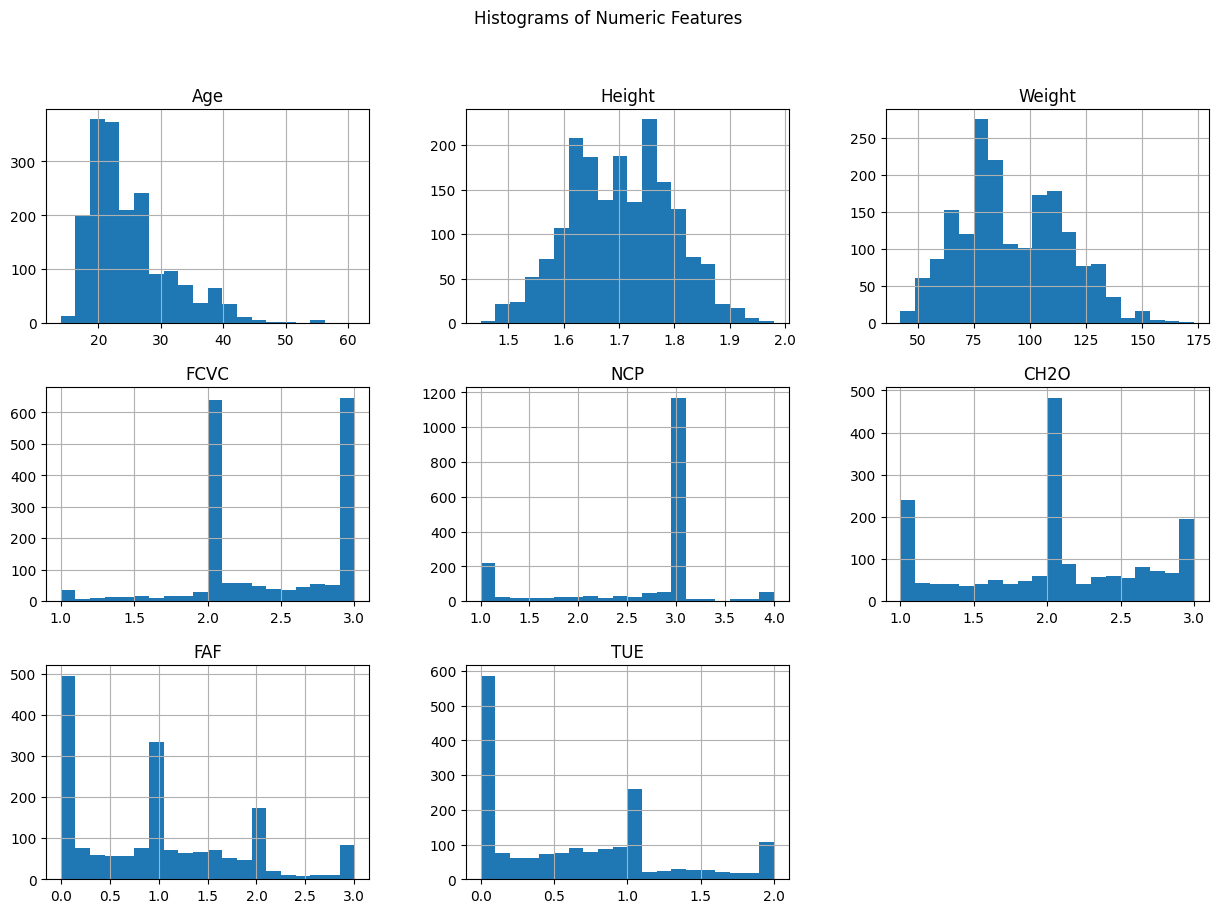

In [10]:
numeric_columns = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
df[numeric_columns].hist(bins=20, figsize=(15, 10))
plt.suptitle("Histograms of Numeric Features")
plt.show()


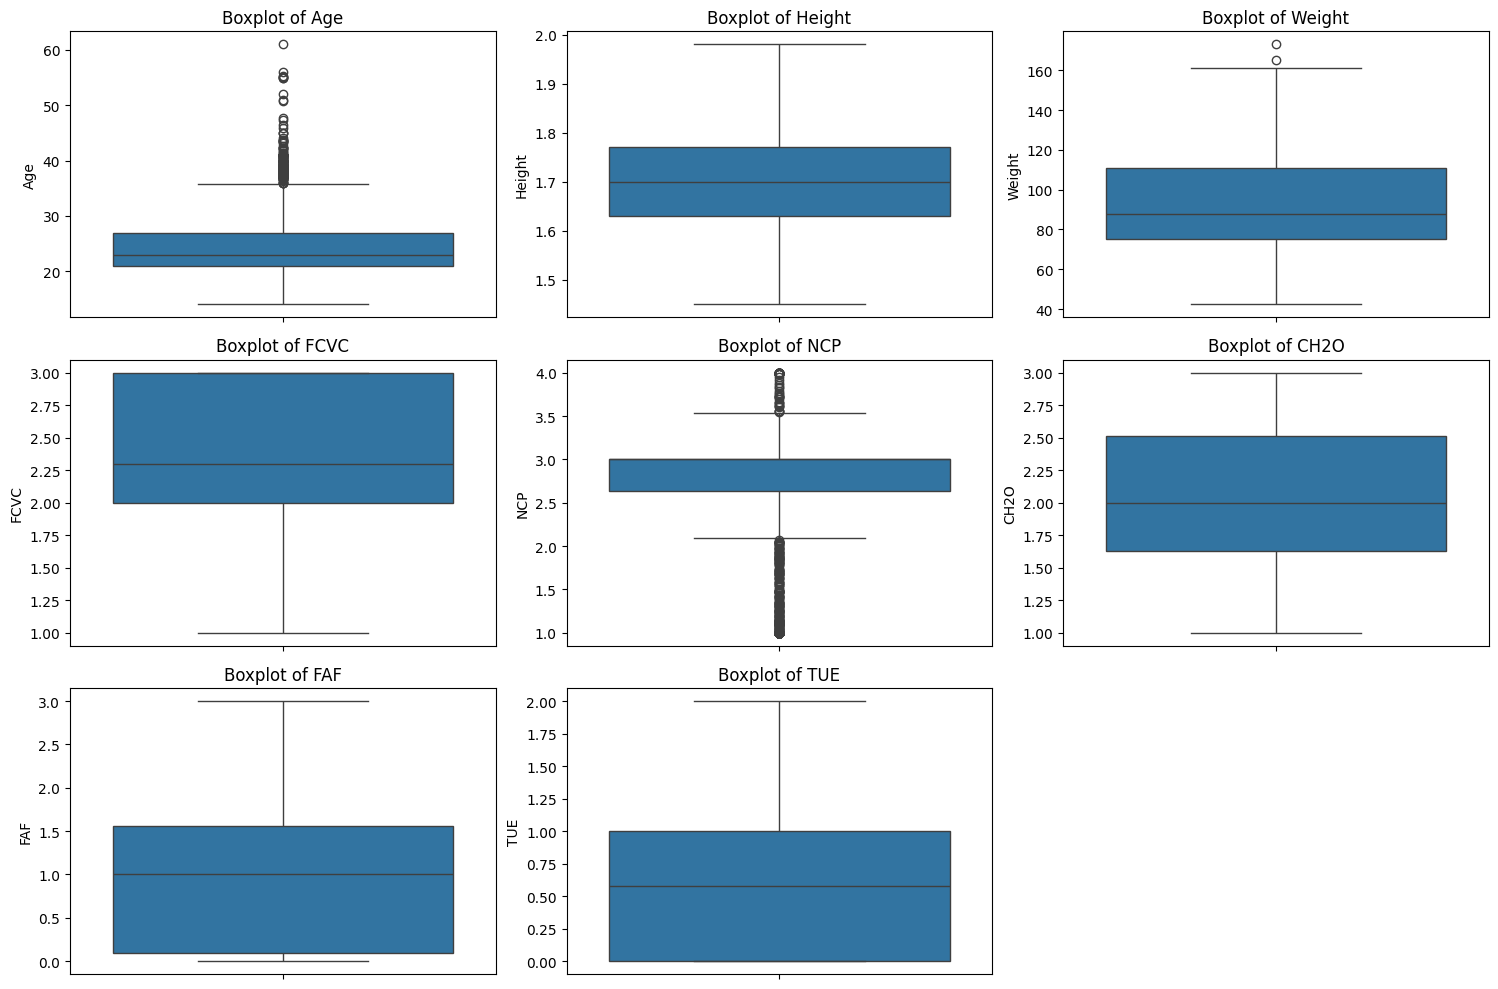

In [11]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


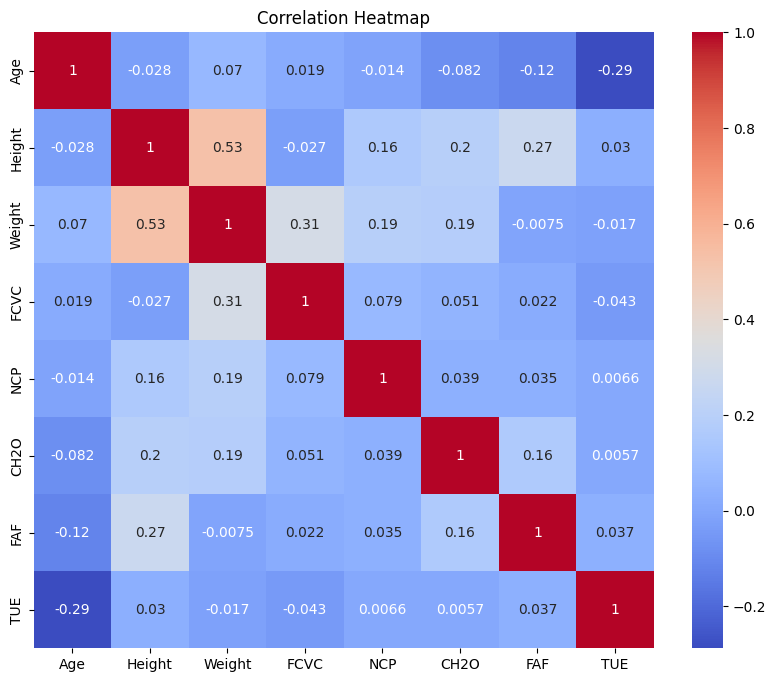

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

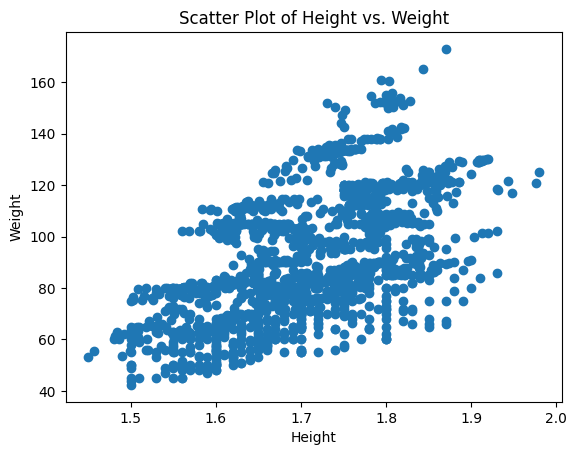

In [13]:
plt.scatter(df['Height'], df['Weight'])

plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Scatter Plot of Height vs. Weight')

plt.show()


In [14]:
df = pd.get_dummies(df, columns = ["Gender", "family_history", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "MTRANS"])

In [15]:
print(df.columns)


Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Obesity', 'Gender_Female', 'Gender_Male', 'family_history_no',
       'family_history_yes', 'FAVC_no', 'FAVC_yes', 'CAEC_Always',
       'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_no', 'SMOKE_yes',
       'SCC_no', 'SCC_yes', 'CALC_Always', 'CALC_Frequently', 'CALC_Sometimes',
       'CALC_no', 'MTRANS_Automobile', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking'],
      dtype='object')


LogisticRegression Model

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the data into features (X) and target (y)
X = df.drop(columns=["Obesity"])
y = df["Obesity"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and fit the Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)  # max_iter set to 1000 to avoid convergence warnings
log_reg.fit(X_train, y_train)

# Evaluate the model on the training data
train_accuracy = log_reg.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Predict on the test data
y_pred = log_reg.predict(X_test)

# Evaluate the model on the test data
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Check for overfitting or underfitting
if train_accuracy > test_accuracy:
    print("Potential Overfitting detected: Higher accuracy on training data than test data.")
elif train_accuracy < test_accuracy:
    print("Potential Underfitting detected: Lower accuracy on training data than test data.")
else:
    print("No significant overfitting or underfitting detected.")

# Classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Training Accuracy: 0.8687
Test Accuracy: 0.8678
Potential Overfitting detected: Higher accuracy on training data than test data.

Classification Report:
                     precision    recall  f1-score   support

      Normal_Weight       0.88      0.86      0.87        87
     Obesity_Type_I       0.84      0.91      0.88       104
    Obesity_Type_II       0.96      1.00      0.98       100
   Obesity_Type_III       0.99      1.00      0.99        91
 Overweight_Level_I       0.74      0.70      0.72        92
Overweight_Level_II       0.76      0.69      0.72        78

           accuracy                           0.87       552
          macro avg       0.86      0.86      0.86       552
       weighted avg       0.86      0.87      0.87       552


Confusion Matrix:
[[ 75   0   0   0  10   2]
 [  0  95   4   1   0   4]
 [  0   0 100   0   0   0]
 [  0   0   0  91   0   0]
 [  8   9   0   0  64  11]
 [  2   9   0   0  13  54]]


c:\Users\nasie\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
X = df.drop(columns=["Obesity"])
y = df["Obesity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'saga'],
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [500, 1000, 2000]
}

grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

train_accuracy = best_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

if train_accuracy > test_accuracy:
    print("Potential Overfitting detected: Higher accuracy on training data than test data.")
elif train_accuracy < test_accuracy:
    print("Potential Underfitting detected: Lower accuracy on training data than test data.")
else:
    print("No significant overfitting or underfitting detected.")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Parameters: {'C': 100, 'max_iter': 500, 'solver': 'newton-cg'}
Training Accuracy: 0.9720
Test Accuracy: 0.9529
Potential Overfitting detected: Higher accuracy on training data than test data.

Classification Report:
                     precision    recall  f1-score   support

      Normal_Weight       0.96      0.93      0.95        87
     Obesity_Type_I       0.95      0.96      0.96       104
    Obesity_Type_II       0.99      0.96      0.97       100
   Obesity_Type_III       1.00      1.00      1.00        91
 Overweight_Level_I       0.89      0.92      0.91        92
Overweight_Level_II       0.91      0.94      0.92        78

           accuracy                           0.95       552
          macro avg       0.95      0.95      0.95       552
       weighted avg       0.95      0.95      0.95       552


Confusion Matrix:
[[ 81   0   0   0   6   0]
 [  0 100   1   0   0   3]
 [  0   4  96   0   0   0]
 [  

RandomForestClassifier

In [18]:
X = df.drop(columns=["Obesity"])
y = df["Obesity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)

train_accuracy = rf_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

y_pred = rf_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")    

if train_accuracy > test_accuracy:
    print("Potential Overfitting detected: Higher accuracy on training data than test data.")
elif train_accuracy < test_accuracy:
    print("Potential Underfitting detected: Lower accuracy on training data than test data.")
else:
    print("No significant overfitting or underfitting detected.")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

Training Accuracy: 1.0000
Test Accuracy: 0.9547
Potential Overfitting detected: Higher accuracy on training data than test data.

Classification Report:
                     precision    recall  f1-score   support

      Normal_Weight       0.85      0.97      0.90        87
     Obesity_Type_I       0.97      0.97      0.97       104
    Obesity_Type_II       1.00      0.99      0.99       100
   Obesity_Type_III       1.00      1.00      1.00        91
 Overweight_Level_I       0.99      0.87      0.92        92
Overweight_Level_II       0.92      0.92      0.92        78

           accuracy                           0.95       552
          macro avg       0.96      0.95      0.95       552
       weighted avg       0.96      0.95      0.96       552


Confusion Matrix:
[[ 84   0   0   0   1   2]
 [  1 101   0   0   0   2]
 [  0   1  99   0   0   0]
 [  0   0   0  91   0   0]
 [ 10   0   0   0  80   2]
 [  4   2   0   0   0  72]]

Feature Importances:
                         Featu

In [19]:
X = df.drop(columns=["Obesity"])
y = df["Obesity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

train_accuracy = best_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

if train_accuracy > test_accuracy:
    print("Potential Overfitting detected: Higher accuracy on training data than test data.")
elif train_accuracy < test_accuracy:
    print("Potential Underfitting detected: Lower accuracy on training data than test data.")
else:
    print("No significant overfitting or underfitting detected.")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

importances = best_model.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(feature_importances)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training Accuracy: 1.0000
Test Accuracy: 0.9547
Potential Overfitting detected: Higher accuracy on training data than test data.

Classification Report:
                     precision    recall  f1-score   support

      Normal_Weight       0.84      0.97      0.90        87
     Obesity_Type_I       0.98      0.97      0.98       104
    Obesity_Type_II       1.00      0.99      0.99       100
   Obesity_Type_III       1.00      1.00      1.00        91
 Overweight_Level_I       0.98      0.87      0.92        92
Overweight_Level_II       0.94      0.92      0.93        78

           accuracy                           0.95       552
          macro avg       0.96      0.95      0.95       552
       weighted avg       0.96      0.95      0.96       552


Confusion Matrix:
[[ 84   0   0   0   1   2]
 [  1 101   0   0   

K-Nearest Kneighbour (KNN)

In [20]:
X = df.drop(columns=["Obesity"])
y = df["Obesity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knn_model = KNeighborsClassifier()

knn_model.fit(X_train, y_train)

train_accuracy = knn_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

y_pred = knn_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

if train_accuracy > test_accuracy:
    print("Potential Overfitting detected: Higher accuracy on training data than test data.")
elif train_accuracy < test_accuracy:
    print("Potential Underfitting detected: Lower accuracy on training data than test data.")
else:
    print("No significant overfitting or underfitting detected.")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Training Accuracy: 0.9316
Test Accuracy: 0.8967
Potential Overfitting detected: Higher accuracy on training data than test data.

Classification Report:
                     precision    recall  f1-score   support

      Normal_Weight       0.90      0.74      0.81        87
     Obesity_Type_I       0.89      0.94      0.92       104
    Obesity_Type_II       0.96      0.96      0.96       100
   Obesity_Type_III       0.98      1.00      0.99        91
 Overweight_Level_I       0.83      0.88      0.85        92
Overweight_Level_II       0.81      0.83      0.82        78

           accuracy                           0.90       552
          macro avg       0.89      0.89      0.89       552
       weighted avg       0.90      0.90      0.90       552


Confusion Matrix:
[[64  1  0  0 14  8]
 [ 0 98  3  0  0  3]
 [ 0  2 96  2  0  0]
 [ 0  0  0 91  0  0]
 [ 5  2  0  0 81  4]
 [ 2  7  1  0  3 65]]


In [21]:
X = df.drop(columns=["Obesity"])
y = df["Obesity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

train_accuracy = best_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

if train_accuracy > test_accuracy:
    print("Potential Overfitting detected: Higher accuracy on training data than test data.")
elif train_accuracy < test_accuracy:
    print("Potential Underfitting detected: Lower accuracy on training data than test data.")
else:
    print("No significant overfitting or underfitting detected.")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Training Accuracy: 1.0000
Test Accuracy: 0.9366
Potential Overfitting detected: Higher accuracy on training data than test data.

Classification Report:
                     precision    recall  f1-score   support

      Normal_Weight       0.93      0.79      0.86        87
     Obesity_Type_I       0.96      0.96      0.96       104
    Obesity_Type_II       0.99      1.00      1.00       100
   Obesity_Type_III       1.00      1.00      1.00        91
 Overweight_Level_I       0.87      0.92      0.89        92
Overweight_Level_II       0.86      0.92      0.89        78

           accuracy                           0.94       552
          macro avg       0.93      0.93      0.93       552
       weighted avg       0.94      0.94      0.94       552


Confusion Matrix:
[[ 69   0   0   0  11   7]
 [  0 100   1   0   0   3]
 [  0   0 100   0

Multi-layer Perceptron (MLP - Neural Network)

In [22]:
X = df.drop(columns=["Obesity"])
y = df["Obesity"]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mlp_model = MLPClassifier(random_state=42, max_iter=1000)

mlp_model.fit(X_train, y_train)

train_accuracy = mlp_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

y_pred = mlp_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

if train_accuracy > test_accuracy:
    print("Potential Overfitting detected: Higher accuracy on training data than test data.")
elif train_accuracy < test_accuracy:
    print("Potential Underfitting detected: Lower accuracy on training data than test data.")
else:
    print("No significant overfitting or underfitting detected.")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Training Accuracy: 1.0000
Test Accuracy: 0.9239
Potential Overfitting detected: Higher accuracy on training data than test data.

Classification Report:
                     precision    recall  f1-score   support

      Normal_Weight       0.87      0.89      0.88        87
     Obesity_Type_I       0.96      0.93      0.95       104
    Obesity_Type_II       0.99      0.97      0.98       100
   Obesity_Type_III       1.00      1.00      1.00        91
 Overweight_Level_I       0.82      0.87      0.85        92
Overweight_Level_II       0.89      0.87      0.88        78

           accuracy                           0.92       552
          macro avg       0.92      0.92      0.92       552
       weighted avg       0.93      0.92      0.92       552


Confusion Matrix:
[[77  0  0  0  7  3]
 [ 0 97  1  0  2  4]
 [ 0  2 97  0  1  0]
 [ 0  0  0 91  0  0]
 [11  0  0  0 80  1]
 [ 1  2  0  0  7 68]]


In [23]:
X = df.drop(columns=["Obesity"])
y = df["Obesity"]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50), (150, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [300, 500, 1000]
}

grid_search = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

train_accuracy = best_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

if train_accuracy > test_accuracy:
    print("Potential Overfitting detected: Higher accuracy on training data than test data.")
elif train_accuracy < test_accuracy:
    print("Potential Underfitting detected: Lower accuracy on training data than test data.")
else:
    print("No significant overfitting or underfitting detected.")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'constant', 'max_iter': 300, 'solver': 'adam'}
Training Accuracy: 1.0000
Test Accuracy: 0.9656
Potential Overfitting detected: Higher accuracy on training data than test data.

Classification Report:
                     precision    recall  f1-score   support

      Normal_Weight       0.91      0.99      0.95        87
     Obesity_Type_I       0.99      0.98      0.99       104
    Obesity_Type_II       1.00      0.99      0.99       100
   Obesity_Type_III       1.00      1.00      1.00        91
 Overweight_Level_I       0.95      0.87      0.91        92
Overweight_Level_II       0.94      0.96      0.95        78

           accuracy                           0.97       552
          macro avg       0.96      0.97      0.96       552
       weighted avg       0.97      0.97      0.97       552


Confusion Matrix:
[[ 86   0  

Support Vector Machine (SVM)

In [24]:
X = df.drop(columns=["Obesity"])
y = df["Obesity"]

numerical_inputs = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_scaled = scaler.fit_transform(X_train[numerical_inputs])
X_test_scaled = scaler.transform(X_test[numerical_inputs])

svm_model = SVC(random_state=42)

svm_model.fit(X_train_scaled, y_train)

train_accuracy = svm_model.score(X_train_scaled, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

y_pred = svm_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

if train_accuracy > test_accuracy:
    print("Potential Overfitting detected: Higher accuracy on training data than test data.")
elif train_accuracy < test_accuracy:
    print("Potential Underfitting detected: Lower accuracy on training data than test data.")
else:
    print("No significant overfitting or underfitting detected.")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Training Accuracy: 0.9518
Test Accuracy: 0.9149
Potential Overfitting detected: Higher accuracy on training data than test data.

Classification Report:
                     precision    recall  f1-score   support

      Normal_Weight       0.89      0.84      0.86        87
     Obesity_Type_I       0.99      0.92      0.96       104
    Obesity_Type_II       0.96      0.98      0.97       100
   Obesity_Type_III       0.99      1.00      0.99        91
 Overweight_Level_I       0.80      0.82      0.81        92
Overweight_Level_II       0.85      0.92      0.88        78

           accuracy                           0.91       552
          macro avg       0.91      0.91      0.91       552
       weighted avg       0.92      0.91      0.92       552


Confusion Matrix:
[[73  0  0  0 13  1]
 [ 0 96  4  0  0  4]
 [ 0  1 98  1  0  0]
 [ 0  0  0 91  0  0]
 [ 9  0  0  0 75  8]
 [ 0  0  0  0  6 72]]


In [25]:
X = df.drop(columns=["Obesity"])
y = df["Obesity"]

numerical_inputs = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_scaled = scaler.fit_transform(X_train[numerical_inputs])

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

grid_search = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

train_accuracy = best_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

if train_accuracy > test_accuracy:
    print("Potential Overfitting detected: Higher accuracy on training data than test data.")
elif train_accuracy < test_accuracy:
    print("Potential Underfitting detected: Lower accuracy on training data than test data.")
else:
    print("No significant overfitting or underfitting detected.")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

joblib.dump(best_model, 'svm_obesity_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X_train.columns.tolist(), 'feature_names.pkl')
print("Model saved as svm_obesity_model.pkl")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Training Accuracy: 0.9860
Test Accuracy: 0.9710
Potential Overfitting detected: Higher accuracy on training data than test data.

Classification Report:
                     precision    recall  f1-score   support

      Normal_Weight       0.96      0.99      0.97        87
     Obesity_Type_I       0.98      0.98      0.98       104
    Obesity_Type_II       1.00      0.99      0.99       100
   Obesity_Type_III       1.00      1.00      1.00        91
 Overweight_Level_I       0.97      0.91      0.94        92
Overweight_Level_II       0.91      0.95      0.93        78

           accuracy                           0.97       552
          macro avg       0.97      0.97      0.97       552
       weighted avg       0.97      0.97      0.97       552


Confusion Matrix:
[[ 86   0   0   0   1   0]
 [  0 102   0   0   0   2]
 [  0   1  99   0   0   0]
 [  0  